# ATP Data Exploratory Data Analysis

https://www.kaggle.com/sijovm/atpdata


## Data description
* tourney_id - tournament_id
* tourney_name - tournament_name
* surface - surface in which the match is played
* draw_size - the size of the draw
* tourney_level - tournament level
    * 'G' = Grand Slams
    * 'M' = Masters 1000s
    * 'A' = other tour-level events
    * 'C' = Challengers
    * 'S' = Satellites/ITFs
    * 'F' = Tour finals and other season-ending events
    * 'D' = Davis Cup
* tourney_date - starting date of the tournament
* match num - match number in a certain tournament
* id - player id
* seed - the seed of the player in that tournament
* entry - How did the player enter the tournaments?
    * WC - Wildcard
    * Q - Qualifier
    * LL - Lucky loser
    * PR - Protected ranking
    * SE - Special Exempt
    * ALT - Alternate player
* name - player name
* hand - hand of the player, right or left
* ht - the height of the player
* IOC - the country of origin
* age - age of the player
* score - final score in the match
* best_of - the maximum number of sets played
* round - the round in the tournament a match belongs to
* minutes - duration of the match in minutes
* ace - number of aces in the match 
* df - double faults
* svpt - serve percent
* 1stin - first serve in percent
* 1stWon - first serve winning percent
* 2ndWon - second serve winning percent
* SvGms - number of games played on serve (So, the maximum difference between w_SvGms and l_SvGms will be 1)
* bpSaved - breakpoints saved
* bpFaced - breakpoints faced
Credits: 1) http://www.tennisabstract.com/ 2) Jeff Sackmann
NOTE: The rankings are available in the other CSVs

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

matches_all = pd.read_csv('../datasets/atpdata/ATP.csv', parse_dates=["tourney_date"])

%matplotlib inline
sns.set()



In [2]:
matches_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169690 entries, 0 to 169689
Data columns (total 49 columns):
best_of               169690 non-null int64
draw_size             1232 non-null float64
l_1stIn               83415 non-null float64
l_1stWon              83415 non-null float64
l_2ndWon              83415 non-null float64
l_SvGms               83415 non-null float64
l_ace                 83415 non-null float64
l_bpFaced             83415 non-null float64
l_bpSaved             83415 non-null float64
l_df                  83415 non-null float64
l_svpt                83415 non-null float64
loser_age             164700 non-null float64
loser_entry           25339 non-null object
loser_hand            169605 non-null object
loser_ht              139052 non-null float64
loser_id              169690 non-null int64
loser_ioc             169690 non-null object
loser_name            169690 non-null object
loser_rank            145909 non-null float64
loser_rank_points     93025 non-nul

## draw size - looks like we don't have draw size past 1968 from this dataset

In [3]:
matches_all[matches_all.draw_size.notnull()][["tourney_id", "tourney_name", "tourney_level", "tourney_date", "draw_size"]].tourney_date.max()

Timestamp('1968-12-30 00:00:00')

## Filter out non-pro tournaments gives us around 59k entries

In [4]:
# exclude other tour-level events, challengers and satellites, and Davis Cup
matches = matches_all[~matches_all.tourney_level.isin(["C", "S", "D"])]
# federer turned pro in 1998 - we will exclude all data before then
matches = matches[matches.tourney_date > datetime.datetime(1998, 1, 1)]

In [5]:
matches.tourney_date.min()

Timestamp('1998-01-05 00:00:00')

In [6]:
matches.tourney_date.max()

Timestamp('2019-02-25 00:00:00')

## Summary of missing data
* Dataset contains tournaments from 1968 to 2/2019
* most players are missing entry - winners are missing more entries than losers. will have to drop this - this might be an important statistic as qualifiers have to play more matches to get into the tournament - we should look at why we are missing this data.
* only a subset of players have seeds - we can impute this based on the player's ranking
* player height - we seem to be missing some - we can probably just impute this with average height from that column 

### Player entry

Entry is supposed to tell you how the player made it into the tournament. We are missing this information for most player.
Looking at the data, it's pretty random:
* we have players that are ranked and seeding
* players that are not seeding but having pretty high rank (ie, < 50)
* players that have lower randkings (ie, > 100)

There is also 'S' in the loser entry which is not explained in the dataset

We should drop this column, since we don't have enough information to impute

In [7]:
print(matches.loser_entry.unique())
print(matches.winner_entry.unique())
print(matches[matches.loser_entry.isnull()].sample(10)[["loser_name", "loser_rank", "loser_seed"]])
print(matches[matches.winner_entry.isnull()].sample(10)[["winner_name", "winner_rank", "winner_seed"]])

[nan 'Q' 'WC' 'LL' 'PR' 'S' 'SE' 'ALT']
[nan 'Q' 'WC' 'LL' 'PR' 'SE' 'ALT']
                loser_name  loser_rank  loser_seed
137820   Rainer Schuettler        90.0         NaN
146889       Frederico Gil        78.0         NaN
111894      Cedric Pioline         6.0         6.0
135748     Boris Pashanski        92.0         NaN
161496   Mikhail Kukushkin        88.0         NaN
130173       Ricardo Mello       147.0         NaN
156480         Yen Hsun Lu        42.0         7.0
165597      Carlos Berlocq        95.0         NaN
137705      Arnaud Clement        91.0         NaN
160106  Stanislas Wawrinka         4.0         4.0
               winner_name  winner_rank  winner_seed
162472        Ivo Karlovic         24.0          3.0
147688        Gael Monfils          7.0          1.0
122057       Stefan Koubek         71.0          NaN
113721       Stefan Koubek         52.0          NaN
113607    Thomas Johansson         57.0          NaN
143275  Paul Henri Mathieu         41.0      

In [8]:
# drop these columns
matches = matches.drop(["draw_size","loser_entry", "winner_entry", "loser_seed", "winner_seed"], axis=1)

In [9]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59764 entries, 103342 to 169689
Data columns (total 44 columns):
best_of               59764 non-null int64
l_1stIn               59164 non-null float64
l_1stWon              59164 non-null float64
l_2ndWon              59164 non-null float64
l_SvGms               59164 non-null float64
l_ace                 59164 non-null float64
l_bpFaced             59164 non-null float64
l_bpSaved             59164 non-null float64
l_df                  59164 non-null float64
l_svpt                59164 non-null float64
loser_age             59764 non-null float64
loser_hand            59764 non-null object
loser_ht              55821 non-null float64
loser_id              59764 non-null int64
loser_ioc             59764 non-null object
loser_name            59764 non-null object
loser_rank            59608 non-null float64
loser_rank_points     59608 non-null float64
match_num             59764 non-null int64
minutes               57858 non-null fl

## Missing Match Stats

* looks like when we are missing data for matches (~600), when we are missing one stat, the rest are missing

In [10]:
matches[matches.l_1stIn.isnull()].sample(10).T

,118077,112833,113127,124406,113055,168857,163376,148543,106737,112822
best_of,3,3,3,3,3,3,3,3,3,3
l_1stIn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_1stWon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_2ndWon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_SvGms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_ace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_bpFaced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_bpSaved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_svpt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Let's see if the tournament has anything to do with the missing stats

To see if there are any tournaments with no stats at all, we add up the stats column - if it's 0 then there means there wer not stats at all

Looks like there are only 4 tournaments where we are completely missing stats

In [11]:
match_stats = matches.groupby("tourney_id").sum()
match_stats[match_stats.l_1stIn == 0]

,best_of,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,...,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_ht,winner_id,winner_rank,winner_rank_points
tourney_id,,,,,,,,,,,,,,,,,,,,,
1998-604,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,275.10,2000.0,1125372,94.0,29235.0
1999-604,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,270.22,2103.0,1128150,131.0,22674.0
2000-96,194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1542.69,11911.0,6582540,3380.0,74757.0
2004-96,194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1569.23,11922.0,6625770,2352.0,82124.0


There are 150 matches in the 4 tournaments that are missing stats, which means there are 450 more from other tournaments

In [12]:
tids = [tid for _, tid in match_stats[match_stats.l_1stIn == 0].reset_index().tourney_id.items()]
print(len(tids))
len(matches[matches.tourney_id.isin(tids)])

4


150

In [13]:
missing_matches = matches[(matches.l_1stIn.isnull()) & (~matches.tourney_id.isin(tids))]
# number of tournaments that are missing matches
len(missing_matches.tourney_id.unique())

344

Most tournaments are only missing a stats for a few matches

In [14]:
missing_matches.tourney_id.value_counts()

2002-741     10
1999-580      9
1999-328      8
2002-410      5
2000-441      4
             ..
2007-423      1
2012-352      1
2010-422      1
1998-326      1
2013-5014     1
Name: tourney_id, Length: 344, dtype: int64

In [15]:
missing_matches["round"].value_counts()

R16     160
R32     111
QF       75
R64      39
SF       32
F        13
RR       13
R128      5
BR        2
Name: round, dtype: int64

## Other Missing Data

* missing height - let's impute this with the average for that column
* minutes (match length) - let's impute this with average match time for each tournament

In [16]:
len(matches[(matches.loser_ht.isnull()) | (matches.winner_ht.isnull())])

5498

In [17]:
# let's figure out specifically how many players are we missing ht
matches.loc[:, "loser_name"] = matches.loser_name.apply(lambda x: x.strip().lower())
matches.loc[:, "winner_name"] = matches.winner_name.apply(lambda x: x.strip().lower())


//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Player Heights')

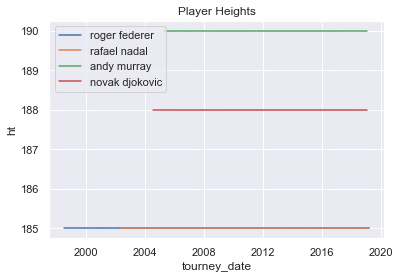

In [18]:
# let's take a closer look at player height and see if it changes over time - we will look at the big 4

def plot_player_height(player: str):
    rf_loser = matches[(matches.loser_name == player)][["tourney_date", "loser_name", "loser_ht"]].rename({"loser_name": "name", "loser_ht": "ht"}, axis=1)
    rf_winner = matches[(matches.winner_name == player)][["tourney_date", "winner_name", "winner_ht"]].rename({"winner_name": "name", "winner_ht": "ht"}, axis=1)
    player_history = rf_loser.append(rf_winner).sort_values("tourney_date")

    sns.lineplot(x=player_history.tourney_date, y=player_history.ht, label=player)
    
    
players = ["roger federer", "rafael nadal", "andy murray", "novak djokovic"]
for player in players:
    plot_player_height(player)
plt.title("Player Heights")

In [19]:
## Let's figure out 

In [20]:
losers = matches[["loser_name", "loser_ht"]].drop_duplicates(subset="loser_name", keep="last").sort_values("loser_name").rename({"loser_name":"name", "loser_ht":"ht"}, axis=1)
winners = matches[["winner_name", "winner_ht"]].drop_duplicates(subset="winner_name", keep="last").sort_values("winner_name").rename({"winner_name":"name", "winner_ht":"ht"}, axis=1)
print(f'unique losers: {len(losers)}')
print(f'unique winners: {len(winners)}')

players = losers.merge(winners, how='outer', on="name")
print(f'Total number of players: {len(players)}')

# how many players do we not have height at all?
print(players[players.ht_x.isnull() & players.ht_y.isnull()])
# are there any players that have loser ht but not winner height?
print(players[players.ht_x.notnull() & players.ht_y.isnull()])
# are there any players that have winner ht but not loser height?
print(players[players.ht_x.isnull() & players.ht_y.notnull()])

unique losers: 1471
unique winners: 967
Total number of players: 1471
                name  ht_x  ht_y
0      abdulla hajji   NaN   NaN
2       adam kennedy   NaN   NaN
3      adam pavlasek   NaN   NaN
4     adrian andreev   NaN   NaN
5      adrian bohane   NaN   NaN
...              ...   ...   ...
1465    zdenek kolar   NaN   NaN
1466        ze zhang   NaN   NaN
1468          zhe li   NaN   NaN
1469   zhizhen zhang   NaN   NaN
1470   zsombor piros   NaN   NaN

[597 rows x 3 columns]
                    name   ht_x  ht_y
16            akash wagh  175.0   NaN
18           alan mackin  183.0   NaN
27          aldin setkic  193.0   NaN
32    aleksandar kitinov  190.0   NaN
42          alex clayton  183.0   NaN
...                  ...    ...   ...
1408       victor ionita  185.0   NaN
1416      vishnu vardhan  188.0   NaN
1418        wade mcguire  188.0   NaN
1442   yasufumi yamamoto  175.0   NaN
1464     zbynek mlynarik  175.0   NaN

[155 rows x 3 columns]
Empty DataFrame
Columns: [name

In [21]:
matches.loser_name.sample(5)

168629         fabio fognini
165079         yuichi sugita
112199    davide sanguinetti
139161          jose acasuso
130578    juan ignacio chela
Name: loser_name, dtype: object

## Let's take a closer look at missing data for minutes

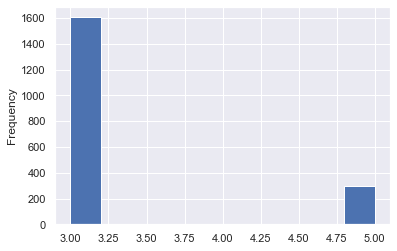

In [22]:
# Let's imput this with the average for the tournament since some have 3 and 
# matches["minutes"] = matches.minutes.fillna(matches.minutes.mean())
matches[matches.minutes.isnull()]["best_of"].plot(kind='hist')

In [23]:
matches[matches.isnull().any(axis=1)].sample(5).T

,162145,163394,165195,160625,154513
best_of,3,3,3,3,3
l_1stIn,47,20,25,39,57
l_1stWon,28,10,15,23,37
l_2ndWon,12,6,6,5,15
l_SvGms,13,4,7,7,14
l_ace,0,0,2,4,2
l_bpFaced,7,8,7,10,9
l_bpSaved,1,6,3,6,5
l_df,2,0,2,5,1
l_svpt,77,31,42,54,88


In [24]:
matches.tourney_level.unique()

array(['A', 'G', 'M', 'F'], dtype=object)

In [25]:
matches.iloc[:5][["loser_name", "winner_name"]]

,loser_name,winner_name
103342,grant stafford,jonas bjorkman
103343,juan antonio marin,jason stoltenberg
103344,alex radulescu,nicolas escude
103345,byron black,thomas johansson
103346,christian ruud,magnus norman


In [26]:
matches.iloc[:5][["loser_ht"]]

,loser_ht
103342,188.0
103343,175.0
103344,185.0
103345,175.0
103346,188.0


In [27]:
matches.score.iloc[:5]

103342        6-4 6-2
103343        6-4 6-1
103344        6-0 7-5
103345        7-5 6-3
103346    6-3 1-6 6-4
Name: score, dtype: object

In [28]:
sorted(matches.tourney_name.unique())

["'s-Hertogenbosch",
 'Acapulco',
 'Adelaide',
 'Amersfoort',
 'Amsterdam',
 'Antalya',
 'Antwerp',
 'Athens Olympics',
 'Atlanta',
 'Auckland',
 'Australian Open',
 'Bangkok',
 'Barcelona',
 'Basel',
 'Bastad',
 'Beijing',
 'Beijing ',
 'Beijing Olympics',
 'Belgrade',
 'Bogota',
 'Bologna',
 'Boston',
 'Bournemouth',
 'Brighton',
 'Brisbane',
 'Bucharest',
 'Budapest',
 'Buenos Aires',
 'Cabo San Lucas',
 'Canada Masters',
 'Casablanca',
 'Chengdu',
 'Chennai',
 'Cincinnati Masters',
 'Copenhagen',
 'Coral Springs',
 'Cordoba',
 'Costa Do Sauipe',
 'Delray Beach',
 'Doha',
 'Dubai',
 'Dusseldorf',
 'Eastbourne',
 'Estoril',
 'Geneva',
 'Grand Slam Cup',
 'Gstaad',
 'Halle',
 'Hamburg',
 'Hamburg Masters',
 'Ho Chi Minh City',
 'Hong Kong',
 'Houston',
 'Indian Wells Masters',
 'Indianapolis',
 'Istanbul',
 'Johannesburg',
 'Kitzbuhel',
 'Kuala Lumpur',
 'Las Vegas',
 'London',
 'London Olympics',
 'Long Island',
 'Los Angeles',
 'Los Cabos',
 'Lyon',
 'Madrid Masters',
 'Mallorca',
 

In [29]:
len(matches.tourney_name.unique())

147

In [30]:
matches.tourney_id.unique()

array(['1998-339', '1998-451', '1998-301', ..., '2019-M004', '2019-0495',
       '2019-0533'], dtype=object)

In [31]:
matches.surface.unique()

array(['Hard', 'Carpet', 'Clay', 'Grass'], dtype=object)

## There are 167 unique tournaments in the dataset

I think tourney_id is a combination of year + unique identifier for tournaments - if take the content after '-' we should have a unique identifier for the tournament

Let's test this out

In [32]:
matches['tourney_id_no_year'] = matches.tourney_id.apply(lambda x: x.split("-")[1])

In [33]:
len(matches.tourney_id_no_year.unique())

167

Let's verify this to make sure they all have the same name

In [52]:
matches.tourney_id_no_year.sample(2).values

array(['419', '573'], dtype=object)

So, it looks like sometimes a tournament

In [67]:
tids = matches.tourney_id_no_year.sample(40).values
matches[matches.tourney_id_no_year.isin(tids)][["tourney_name","tourney_id_no_year"]].drop_duplicates().sort_values("tourney_id_no_year")

,tourney_name,tourney_id_no_year
162830,Metz,0341
119933,Madrid Masters,1536
122886,Bangkok,1720
104609,Munich,308
105096,Queen's Club,311
106570,Vienna,337
103435,Sydney Outdoor,338
107024,Sydney,338
103342,Adelaide,339
139409,Brisbane,339


In [71]:
matches[matches.tourney_id_no_year == '433'][["tourney_name", "tourney_id_no_year", "tourney_id"]].drop_duplicates()

,tourney_name,tourney_id_no_year,tourney_id
103951,Scottsdale,433,1998-433
107494,Scottsdale,433,1999-433
110993,Scottsdale,433,2000-433
114393,Scottsdale,433,2001-433
117650,Scottsdale,433,2002-433
120856,Scottsdale,433,2003-433
124042,Scottsdale,433,2004-433
127257,Scottsdale,433,2005-433
130610,Las Vegas,433,2006-433
133859,Las Vegas,433,2007-433


## ATP says there are 68 tournaments in a year that counts for points, let's verify this number by looking at 2017 and 2018

In [ ]:
len(matches[(matches.tourney_date > datetime.datetime(2017, 12, 31)) & (matches.tourney_date < datetime.datetime(2019,1,1))].tourney_name.unique())

In [ ]:
# got the following warning when reading in data frame 
# //anaconda3/envs/sb/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
#  interactivity=interactivity, compiler=compiler, result=result)
# this is actually WRank and LRank columns - going to set them explicitly to object
# for players that are not ranked yet, you get NR in this columns
import numpy as np
data = pd.read_csv('../datasets/atp-tour-20002016/Data.csv', parse_dates=["Date"], dtype={'WRank': object, 'LRank': object}, encoding='ISO-8859-1')


In [ ]:
data.info()

In [ ]:
data.sample(5).T

In [ ]:
data.Series.unique()

In [ ]:
data[(data.WRank == 'NR') | (data.LRank == 'NR')][["ATP", "Location", "Tournament", "WRank", "LRank"]]

In [ ]:
# columns = data.columns
# for col in columns:
#     print(f'{col}: {data.columns.get_loc(col)}')

In [ ]:
data[data.Date > datetime.datetime(1998,1,1)].Tournament.unique()

In [ ]:
data.Loser.unique()